<a href="https://colab.research.google.com/github/sridhars03/stella_vslam_benchmark_fusion_/blob/main/src/stella_vslam/fusion/RNN_LSTM_colab_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports here
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#################
#GT

#make a case to ignore first row if there is string
def read_ground_truth(file_path):

    with open(file_path, 'r') as f:
        first_line = f.readline().strip().split()

    #trying to convert the first row to float
    try:
        float(first_line[0])
        data = np.loadtxt(file_path)
    except ValueError:
        data = np.loadtxt(file_path, skiprows=1)

    data = data[:,1:]
    return data

ground_truth = read_ground_truth('/content/drive/MyDrive/GEData/traindata/data.tum')
print(ground_truth[:2])

[[ 4.688319 -1.786938  0.783338 -0.153029 -0.827383 -0.082152  0.534108]
 [ 4.688177 -1.78677   0.78735  -0.15299  -0.826976 -0.082863  0.53464 ]]


In [ ]:
#################
#SLAM trajectory outputs
#************Synchronized trajs*********

def read_traj_outputs(file_path):
    data = np.loadtxt(file_path)
    data = data[:,1:]
    return data

In [ ]:
#TRAINING INPUT DATA
#without the timestamps


poses_orb = read_traj_outputs('/content/drive/MyDrive/GEData/traindata/synchronized_trajectory_orb.txt')  #orb
poses_openvslam = read_traj_outputs('/content/drive/MyDrive/GEData/traindata/synchronized_trajectory_openvslam.txt')  #openvslam
print(poses_orb[0])
print(poses_openvslam[0])

#GT ll have different size. how to sync GT with these 2??
#actual method: before doing synchronizing, check which has smaller size-then sync with that traj.txt
#confusion with usual NN - train bunch of imgs (input)-target-label.
#here - train one big traj file - target-also traj file, when I train with another set of traj vs GT, will it undo the prev training?

[ 8.88630000e-05  5.91599200e-03  2.39101500e-03 -6.70326000e-04
  4.79890100e-03 -2.76314300e-03  9.99984443e-01]
[ 9.13133482e-04 -2.98736960e-02 -1.01476047e-02  2.41644905e-02
 -6.52941544e-04 -4.76142127e-03  9.99696444e-01]


In [ ]:
#*******************SYNC GT WITH Traj.txt

def read_trajectory(file_path):
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, dtype={0: float})
    data.columns = ['timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw']
    return data

def find_nearest_unique_timestamps(reference_timestamps, target_timestamps):
    #store the indices of the nearest unique timestamps
    nearest_indices = []
    used_indices = set()

    for ref_time in reference_timestamps:
        #absolute difference between the reference timestamp and all target timestamps
        differences = np.abs(target_timestamps - ref_time)
        #mask the already used indices
        differences[list(used_indices)] = np.inf
        #find the index of least difference n makring as used
        nearest_index = np.argmin(differences)
        nearest_indices.append(nearest_index)
        used_indices.add(nearest_index)

    return nearest_indices

#this step-redundant. use from above.
trajectory_openvslam = read_trajectory('/content/drive/MyDrive/GEData/traindata/synchronized_trajectory_openvslam.txt')
trajectory_gt = read_trajectory('/content/drive/MyDrive/GEData/traindata/data.tum')

#extract timestamps
timestamps_gt = trajectory_gt['timestamp'].values
timestamps_openvslam = trajectory_openvslam['timestamp'].values

#find nearest timestamps in OpenVSLAM for ORB-SLAM3 timestamps
nearest_indices = find_nearest_unique_timestamps(timestamps_openvslam,timestamps_gt)
synchronized_gt = trajectory_gt.iloc[nearest_indices].reset_index(drop=True)

synchronized_gt.to_csv('/content/drive/MyDrive/GEData/traindata/synchronized_gt.txt', sep=' ',header=False,index=False)
print("**************")

assert synchronized_gt.shape[0] == poses_orb.shape[0] == poses_openvslam.shape[0], "Mismatch in number of samples"

synchronized_gt_numpy = synchronized_gt.to_numpy()    #changning pandas DF to numpy

<ipython-input-32-70105c363346>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None, dtype={0: float})
<ipython-input-32-70105c363346>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None, dtype={0: float})


**************


In [ ]:
train_input_traj = np.concatenate((poses_orb, poses_openvslam), axis=1) #without timestamps
target_input_traj = synchronized_gt_numpy[:,1:]  #without timestamps
print("targetinput,traininput shapes: ",target_input_traj.shape, train_input_traj.shape)

# SEQUENCE FOR LSTM
sequence_length = 5
num_sequences = train_input_traj.shape[0] - sequence_length
X = np.array([train_input_traj[i:i+sequence_length] for i in range(num_sequences)])
y = np.array([target_input_traj[i+sequence_length] for i in range(num_sequences)])
print(X.shape,y.shape)

targetinput,traininput shapes:  (3680, 7) (3680, 14)
(3675, 5, 14) (3675, 7)


In [ ]:
#Model
def create_model(lstm_units=128, dropout_rate=0.2, learning_rate=0.001):
    """Create and compile the LSTM model."""
    model = Sequential([
        LSTM(lstm_units, return_sequences=False, input_shape=(sequence_length, 7*2)),
        Dropout(dropout_rate),
        Dense(7, activation='relu')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [ ]:
#Train+Eval
def train_and_evaluate(X_train, y_train, X_val, y_val, lstm_units, dropout_rate, learning_rate):
    model = create_model(lstm_units, dropout_rate, learning_rate)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    return model,history

In [ ]:
#Hyperparameters
#for v101 training: 5 lowest val loss - (128,5,0.2,0.01),(64,5,0.2,0.01),(128,5,0.3,0.001),(128,5,0.2,0.001),(128,5,0.3,0.01)

#updated list of necessary params
lstm_units_list = [32, 64, 128]  #different LSTM units
sequence_lengths = [3, 5]  # Different sequence lengths
dropout_rates = [0.2, 0.3, 0.4]  # Different dropout values
learning_rates = [0.01, 0.001]  # Different learning rates

results = []
best_model = None
best_val_loss = float('inf')

In [ ]:
#Iterate through each combination of parameters
for lstm_units in lstm_units_list:
    for seq_length in sequence_lengths:
        X_seq = np.array([train_input_traj[i:i + seq_length] for i in range(train_input_traj.shape[0] - seq_length)])
        y_seq = np.array([target_input_traj[i + seq_length] for i in range(train_input_traj.shape[0] - seq_length)])

        X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.1, random_state=42)

        for dropout_rate in dropout_rates:
            for learning_rate in learning_rates:
                print(f"Training with LSTM units: {lstm_units}, Seq Length: {seq_length}, Dropout: {dropout_rate}, Learning Rate: {learning_rate}")

                ############ Training ##############
                model, history = train_and_evaluate(X_train, y_train, X_val, y_val, lstm_units, dropout_rate, learning_rate)
                val_loss = np.min(history.history['val_loss'])
                results.append((lstm_units, seq_length, dropout_rate, learning_rate, history, val_loss))

                #choosing the best model(based on val loss)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model

Training with LSTM units: 32, Seq Length: 3, Dropout: 0.2, Learning Rate: 0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with LSTM units: 32, Seq Length: 3, Dropout: 0.2, Learning Rate: 0.001
Training with LSTM units: 32, Seq Length: 3, Dropout: 0.3, Learning Rate: 0.01
Training with LSTM units: 32, Seq Length: 3, Dropout: 0.3, Learning Rate: 0.001
Training with LSTM units: 32, Seq Length: 3, Dropout: 0.4, Learning Rate: 0.01
Training with LSTM units: 32, Seq Length: 3, Dropout: 0.4, Learning Rate: 0.001
Training with LSTM units: 32, Seq Length: 5, Dropout: 0.2, Learning Rate: 0.01
Training with LSTM units: 32, Seq Length: 5, Dropout: 0.2, Learning Rate: 0.001
Training with LSTM units: 32, Seq Length: 5, Dropout: 0.3, Learning Rate: 0.01
Training with LSTM units: 32, Seq Length: 5, Dropout: 0.3, Learning Rate: 0.001
Training with LSTM units: 32, Seq Length: 5, Dropout: 0.4, Learning Rate: 0.01
Training with LSTM units: 32, Seq Length: 5, Dropout: 0.4, Learning Rate: 0.001
Training with LSTM units: 64, Seq Length: 3, Dropout: 0.2, Learning Rate: 0.01
Training with LSTM units: 64, Seq Length: 3, D

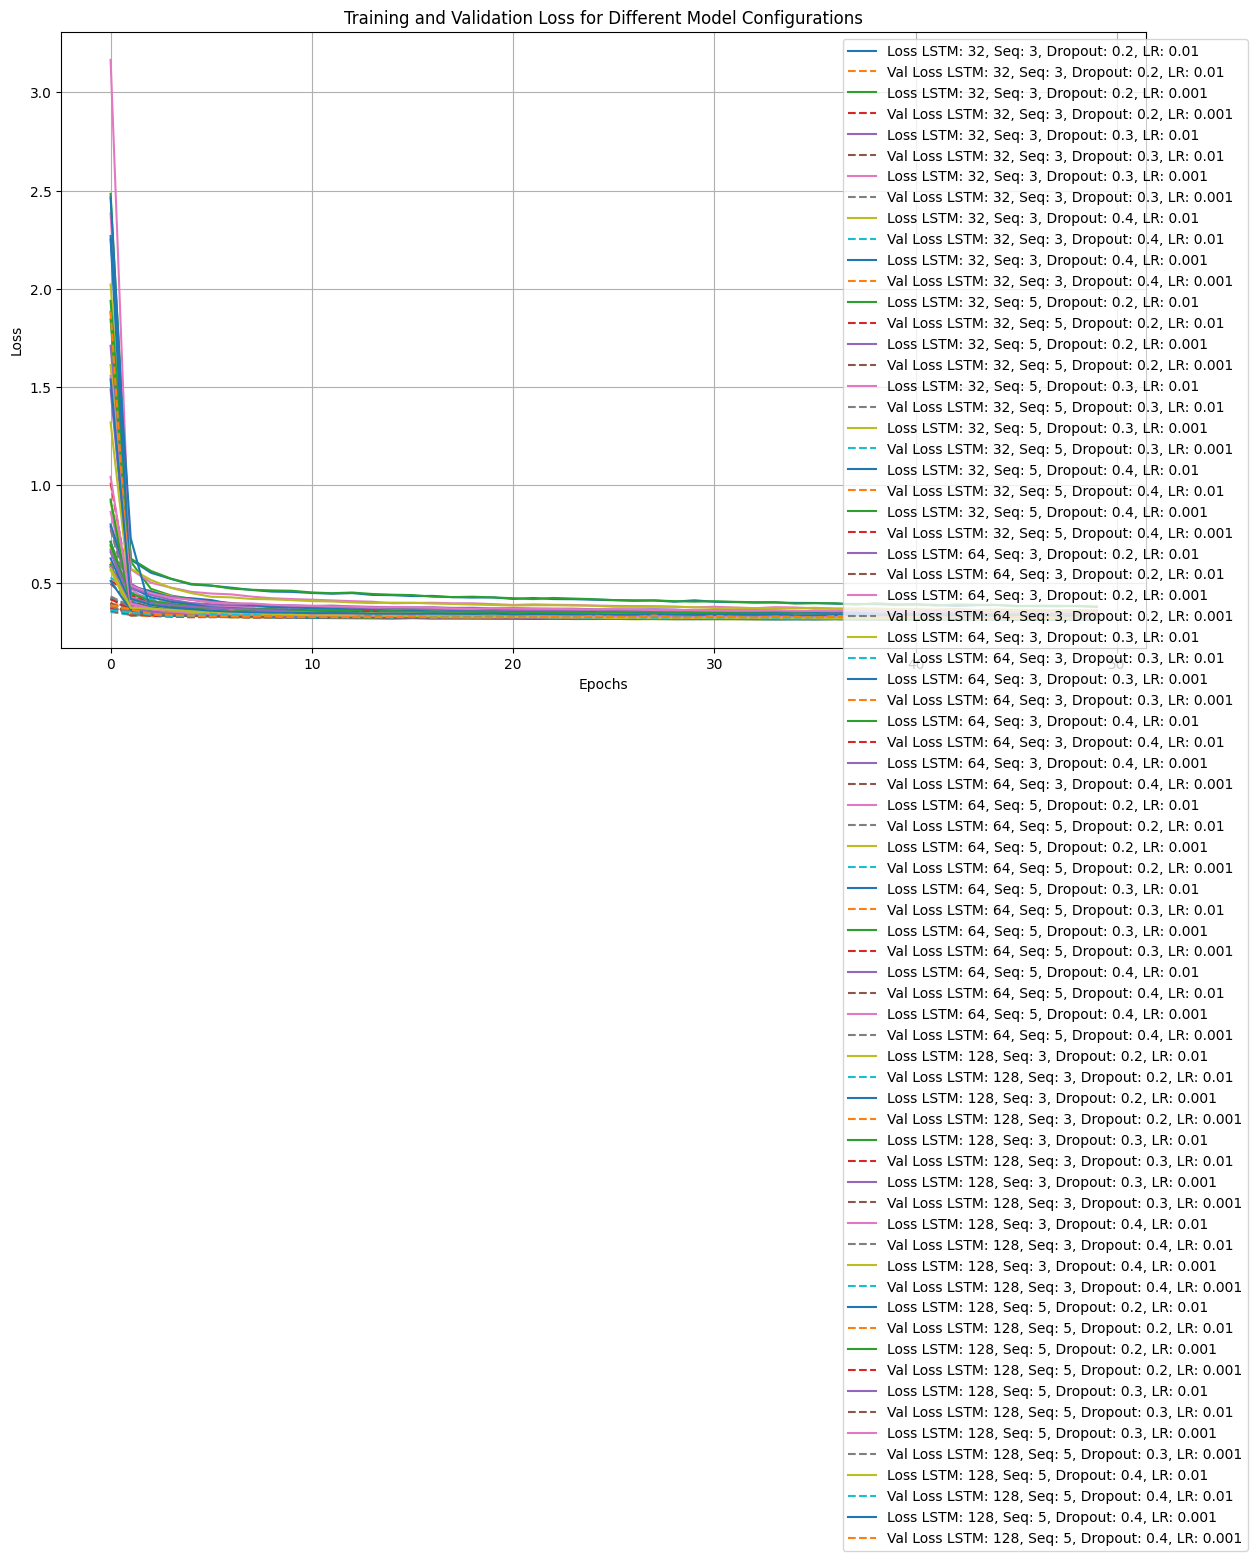

In [ ]:
#Plot performance - every param permutation..
plt.figure(figsize=(14, 8))
for (lstm_units, seq_length, dropout_rate, learning_rate, history, val_loss) in results:
    plt.plot(history.history['loss'], label=f'Loss LSTM: {lstm_units}, Seq: {seq_length}, Dropout: {dropout_rate}, LR: {learning_rate}')
    plt.plot(history.history['val_loss'], label=f'Val Loss LSTM: {lstm_units}, Seq: {seq_length}, Dropout: {dropout_rate}, LR: {learning_rate}', linestyle='dashed')

plt.title('Training and Validation Loss for Different Model Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

In [ ]:
#Test Data
test_traj_orb = read_traj_outputs('/content/drive/MyDrive/GEData/testdata/synchronized_trajectory_orbmh05.txt')
test_traj_openvslam = read_traj_outputs('/content/drive/MyDrive/GEData/testdata/synchronized_trajectory_openvslammh05.txt')
print(test_traj_orb.shape)

(2193, 7)


In [ ]:
#Prepare sequences for testing/feeding into rnn
test_sequences = []
for i in range(len(test_traj_orb) - sequence_length + 1):
    orb_seq = test_traj_orb[i:i + sequence_length]
    openvslam_seq = test_traj_openvslam[i:i + sequence_length]
    combined_seq = np.concatenate((orb_seq, openvslam_seq), axis=1)
    test_sequences.append(combined_seq)

test_sequences = np.array(test_sequences)

print(test_sequences.shape)  # (num_test_sequences, sequence_length, 14)

(2189, 5, 14)


In [ ]:
#Prediction
predicted_traj = best_model.predict(test_sequences)
print(predicted_traj.shape)  # (num of samples - seq length + 1, 7)
print(predicted_traj[0]) #Just to check initial val

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(2189, 7)
[4.668231 0.       1.045023 0.       0.       0.       0.56142 ]


In [ ]:
#Here we mimic timestamps and add to result trajectory
test_openvslam_with_timestamps = np.loadtxt('/content/drive/MyDrive/GEData/testdata/synchronized_trajectory_openvslammh05.txt')

avg_timegap = (test_openvslam_with_timestamps[-1][0] - test_openvslam_with_timestamps[0][0]) / (test_openvslam_with_timestamps.shape[0] - 1)
print(avg_timegap)
fake_timestamp = np.arange(test_openvslam_with_timestamps[0][0], test_openvslam_with_timestamps[0][0] + predicted_traj.shape[0] * avg_timegap, avg_timegap).reshape(-1, 1)
result_with_timestamps = np.hstack((fake_timestamp, predicted_traj))

0.04999999995649296


In [ ]:
np.savetxt('/content/drive/MyDrive/GEData/Results/mh05withmh01.txt', result_with_timestamps, delimiter=' ', fmt='%f')